# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844


In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
# change to your folder directory
# %cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
%cd "/content/drive/MyDrive/EE247_FinalProject/project"

Mounted at /content/drive
/content/drive/MyDrive/EE247_FinalProject/project


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

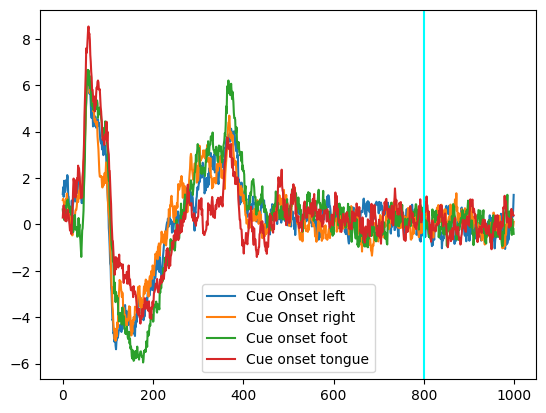

In [ ]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [ ]:
def train_data_prep(X,y,sub_sample,average,noise,time_sel):
    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    return total_X,total_y



def data_prep_stft(data_x):
    fs = 250
    nperseg = 100
    _, _, X_stft = signal.stft(data_x, fs=fs, nperseg=nperseg, nfft=nperseg)  # keep the same frequency bins, pad on time
    return np.abs(X_stft)


def data_lpc(data_x):
    X_lpc = librosa.lpc(data_x, order=15)
    return X_lpc


def data_cep(data_x):
    X_mfcc = librosa.feature.mfcc(y=data_x, sr=250, n_fft=50, n_mfcc=39)
    X_cep = np.max(X_mfcc, axis=-1)
    return X_cep


def val_test_data_prep(X,time_sel):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [ ]:
def data_loader(X_train_valid, y_train_valid, model_choice="EEG", time_sel=800, z_norm=False):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True,time_sel)

    if z_norm == True:
        for i in range(train_data_aug.shape[0]):
            feature_map = train_data_aug[i]
            ch_mean = np.mean(feature_map, axis=0)
            ch_std = np.sqrt(np.var(feature_map, axis=0))
            train_data_aug[i] = np.divide(feature_map-ch_mean, ch_std)

        for i in range(train_data.shape[0]):
            feature_map = train_data[i]
            ch_mean = np.mean(feature_map, axis=0)
            ch_std = np.sqrt(np.var(feature_map, axis=0))
            train_data[i] = np.divide(feature_map-ch_mean, ch_std)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)

    if model_choice == "EEG":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])

    if model_choice == "STFT":
        train_data_stft_raw = data_prep_stft(train_data)    # STFT on untruncated data
        train_data_stft_aug = data_prep_stft(train_data_aug)    # STFT on filtered data
        train_data_stft_aug_zp = np.zeros([train_data_stft_aug.shape[0], train_data_stft_aug.shape[1], train_data_stft_aug.shape[2], train_data_stft_raw.shape[-1]])
        train_data_stft_aug_zp[:,:,:,0:train_data_stft_aug.shape[-1]] = train_data_stft_aug
        train_data_aug = np.concatenate((train_data_stft_raw, train_data_stft_aug_zp), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)

    if model_choice == "Speech":
        train_data_lpc= data_lpc(train_data)
        train_data_cep = data_cep(train_data)
        train_data_aug_lpc = data_lpc(train_data_aug)
        train_data_aug_cep = data_cep(train_data_aug)
        train_data_speech = np.concatenate((train_data_lpc,train_data_cep), axis=-1)
        train_data_aug_speech= np.concatenate((train_data_aug_lpc,train_data_aug_cep), axis=-1)
        train_data_aug = np.concatenate((train_data_speech, train_data_aug_speech), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)


    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data, time_sel)

    if z_norm == True:
        for i in range(val_data_aug.shape[0]):
            feature_map = val_data_aug[i]
            ch_mean = np.mean(feature_map, axis=0)
            ch_std = np.sqrt(np.var(feature_map, axis=0))
            val_data_aug[i] = np.divide(feature_map-ch_mean, ch_std)

        for i in range(val_data.shape[0]):
            feature_map = val_data[i]
            ch_mean = np.mean(feature_map, axis=0)
            ch_std = np.sqrt(np.var(feature_map, axis=0))
            val_data[i] = np.divide(feature_map-ch_mean, ch_std)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)

    if model_choice == "EEG":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])

    if model_choice == "STFT":
        val_data_aug = data_prep_stft(val_data_aug)
        val_stft_aug_zp = np.zeros([val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], train_data_stft_raw.shape[-1]])
        val_stft_aug_zp[:,:,:,0:val_data_aug.shape[-1]] = val_data_aug
        val_data_aug = val_stft_aug_zp

    if model_choice == "Speech":
        val_data_aug_lpc = data_lpc(val_data_aug)
        val_data_aug_cep = data_cep(val_data_aug)
        val_data_aug = np.concatenate((val_data_aug_lpc,val_data_aug_cep), axis=-1)
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)



    print("My training data: ", train_data_aug.shape)
    print("My training label: ", train_label_aug.shape)
    print()
    print("My val data: ", val_data_aug.shape)
    print("My val label: ", val_label.shape)
    print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data
    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [ ]:
np.random.seed(247)
x_train_CNN, y_train_CNN, x_valid_CNN, y_valid_CNN= data_loader(X_train_valid, y_train_valid, model_choice="CNN")
x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG = data_loader(X_train_valid, y_train_valid, model_choice="EEG")
x_train_STFT, y_train_STFT, x_valid_STFT, y_valid_STFT = data_loader(X_train_valid, y_train_valid, model_choice="STFT")
x_train_Speech, y_train_Speech, x_valid_Speech, y_valid_Speech = data_loader(X_train_valid, y_train_valid, model_choice="Speech")
x_train_EEG_z, y_train_EEG_z, x_valid_EEG_z, y_valid_EEG_z = data_loader(X_train_valid, y_train_valid, model_choice="EEG", z_norm=True)

My training data:  (6768, 22, 400, 1)
My training label:  (6768,)

My val data:  (423, 22, 400, 1)
My val label:  (423,)

My training data:  (6768, 1, 22, 400)
My training label:  (6768,)

My val data:  (423, 1, 22, 400)
My val label:  (423,)

My training data:  (8460, 22, 51, 21)
My training label:  (8460,)

My val data:  (423, 22, 51, 21)
My val label:  (423,)



/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


My training data:  (8460, 22, 55, 1)
My training label:  (8460,)

My val data:  (423, 22, 55, 1)
My val label:  (423,)

My training data:  (6768, 1, 22, 400)
My training label:  (6768,)

My val data:  (423, 1, 22, 400)
My val label:  (423,)



In [ ]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [ ]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30, anneal_=False, scheduler_coeff = 10, T_mult=1):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    if anneal_ == True:
        print("Annealing")
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations*scheduler_coeff)

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    np.random.seed(247)
    torch.manual_seed(147)
    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            if anneal_ == True:
                scheduler.step()
                # print(scheduler.get_last_lr())

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            print("Check: ", x_valid.shape)
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))


        if (anneal_ == True) and ((epoch+1) % scheduler_coeff == 0):
            print('Reset scheduler after finishing epoch: ', epoch+1)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_mult=T_mult, T_0=num_iterations*scheduler_coeff)

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [ ]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, model_choice="CNN", X_test=X_test, y_test=y_test,time_sel=800, z_norm=False):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test,time_sel)

    if z_norm == True:
        for i in range(x_test.shape[0]):
            feature_map = x_test[i]
            ch_mean = np.mean(feature_map, axis=0)
            ch_std = np.sqrt(np.var(feature_map, axis=0))
            x_test[i] = np.divide(feature_map-ch_mean, ch_std)

    if model_choice == "STFT":
        x_test = data_prep_stft(x_test)
        x_test_zp = np.zeros([x_test.shape[0], x_test.shape[1], x_test.shape[2], x_train_STFT.shape[-1]])
        x_test_zp[:,:,:,0:x_test.shape[-1]] = x_test
        x_test = x_test_zp

    if model_choice == "Speech":
        x_test_lpc = data_lpc(x_test)
        x_test_cep = data_cep(x_test)
        x_test = np.concatenate((x_test_lpc,x_test_cep), axis=-1)


    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN" or model_choice == "Speech":
            x_test = x_test.unsqueeze(-1)

        if model_choice == "EEG":
            x_test = x_test.unsqueeze(1)


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", model_choice, "is: ", test_acc)


# **MODEL DEFINITION**





> Here, we define the models and the data augmentation / regularization techinques used in this third experiment. Our models are:
1.  CNN+Short Time Fourier Transform Augmented Data
2.  CNN+LPC&Cepstrum (Speech Recognition Features) Augmented Dara
3.  EEGNet+Cosine Annealing
4.  EEGNet+Label Smoothing
5.  EEGNet+Z-score Normalization

In [ ]:
###################################################################################
## Classification with a CNN + STFT Augmentation ##################################
###################################################################################
class STFTNet(nn.Module):
    def __init__(self):
        super(STFTNet, self).__init__()

        layers=[]

        layers.append(nn.Conv2d(in_channels=22, out_channels=25, kernel_size=1, stride=1, padding='same'))   # Inceprtion for channel dim reduction
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.BatchNorm2d(25))
        layers.append(nn.Dropout(p=0.5))


        layers.append(nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.BatchNorm2d(50))
        layers.append(nn.Dropout(p=0.5))


        layers.append(nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.BatchNorm2d(100))
        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(1200,600))
        layers.append(nn.Linear(600,40))
        layers.append(nn.Linear(40,10))

        layers.append(nn.Linear(10,4))
        self.model = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model:
            x = layer(x)
            # print(layer)
            # print(x.shape)
            # print()


        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
stft_cnn = STFTNet().to(device)
summary(stft_cnn, input_size=x_train_STFT[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
STFTNet                                  [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 25, 51, 21]          575
│    └─ELU: 2-2                          [64, 25, 51, 21]          --
│    └─MaxPool2d: 2-3                    [64, 25, 25, 10]          --
│    └─BatchNorm2d: 2-4                  [64, 25, 25, 10]          50
│    └─Dropout: 2-5                      [64, 25, 25, 10]          --
│    └─Conv2d: 2-6                       [64, 50, 25, 10]          31,300
│    └─ELU: 2-7                          [64, 50, 25, 10]          --
│    └─MaxPool2d: 2-8                    [64, 50, 12, 5]           --
│    └─BatchNorm2d: 2-9                  [64, 50, 12, 5]           100
│    └─Dropout: 2-10                     [64, 50, 12, 5]           --
│    └─Conv2d: 2-11                      [64, 100, 12, 5]          125,100
│   

In [ ]:
###################################################################################
## Classification with a CNN + LPC&Cepstrum Augmentation ##########################
###################################################################################
class CNN_Speech(nn.Module):
    def __init__(self):
        super(CNN_Speech, self).__init__()

        # Block 1
        layers=[]
        layers.append(nn.Conv2d(in_channels=22, out_channels=25, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(25))
        layers.append(nn.Dropout(p=0.6))

        # Block 2
        layers.append(nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1, padding='same'))
        layers.append(nn.ELU())
        layers.append(nn.MaxPool2d(kernel_size=(3,1), padding=(1,0), stride=(3,1)))
        layers.append(nn.BatchNorm2d(50))
        layers.append(nn.Dropout(p=0.6))

        # FC Layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(350,40))
        layers.append(nn.Linear(40,10))
        layers.append(nn.Linear(10,4))
        self.model_nn = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model_nn:
            x = layer(x)

        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn_speech = CNN_Speech().to(device)
summary(cnn_speech, input_size=x_train_Speech[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Speech                               [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 25, 55, 1]           13,775
│    └─ELU: 2-2                          [64, 25, 55, 1]           --
│    └─MaxPool2d: 2-3                    [64, 25, 19, 1]           --
│    └─BatchNorm2d: 2-4                  [64, 25, 19, 1]           50
│    └─Dropout: 2-5                      [64, 25, 19, 1]           --
│    └─Conv2d: 2-6                       [64, 50, 19, 1]           31,300
│    └─ELU: 2-7                          [64, 50, 19, 1]           --
│    └─MaxPool2d: 2-8                    [64, 50, 7, 1]            --
│    └─BatchNorm2d: 2-9                  [64, 50, 7, 1]            100
│    └─Dropout: 2-10                     [64, 50, 7, 1]            --
│    └─Flatten: 2-11                     [64, 350]                 --
│    └

In [ ]:
###########################################################
## Classification with a EEG NET ##########################
###########################################################
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()     #EEGNet is a subclass for nn.Module base class

        layers=[]
        num_classes=4
        num_channel = 22
        fs = 250
        dropoutRate = 0.25
        filter_len = fs//2
        F1 = 8
        D = 2
        F2 = 16

        layers = []
        # Block 1
        # Input shape: N*1*C*T
        layers.append(nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=[1, filter_len], padding='same', bias=False))
        layers.append(nn.BatchNorm2d(num_features=F1))
        layers.append(ConstrainedConv2d(in_channels=F1, out_channels=D*F1, groups=F1, kernel_size=[num_channel, 1], padding='valid', bias=False))
        layers.append(nn.BatchNorm2d(num_features=D*F1))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,4]))
        layers.append(nn.Dropout(dropoutRate))

        #Block2
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=D*F1, groups=D*F1, kernel_size=[1, filter_len//2], padding="same"))
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=1))
        layers.append(nn.BatchNorm2d(num_features=F2))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,8]))
        layers.append(nn.Dropout(dropoutRate))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=192, out_features=100))
        layers.append(nn.Linear(in_features=100, out_features=10))
        layers.append(nn.Linear(in_features=10, out_features=num_classes))

        self.model = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model:
            x = layer(x)

        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eeg_net = EEGNet().to(device)
summary(eeg_net, input_size=x_train_EEG[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 8, 22, 400]          1,000
│    └─BatchNorm2d: 2-2                  [64, 8, 22, 400]          16
│    └─ConstrainedConv2d: 2-3            [64, 16, 1, 400]          352
│    └─BatchNorm2d: 2-4                  [64, 16, 1, 400]          32
│    └─ELU: 2-5                          [64, 16, 1, 400]          --
│    └─AvgPool2d: 2-6                    [64, 16, 1, 100]          --
│    └─Dropout: 2-7                      [64, 16, 1, 100]          --
│    └─Conv2d: 2-8                       [64, 16, 1, 100]          1,008
│    └─Conv2d: 2-9                       [64, 16, 1, 100]          272
│    └─BatchNorm2d: 2-10                 [64, 16, 1, 100]          32
│    └─ELU: 2-11                         [64, 16, 1, 100]          --
│    └─

# **Training Our Models**

In [ ]:
###################################################################################
## Training and Test The CNN+STFT #################################################
###################################################################################
stft_cnn = STFTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(stft_cnn.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_stft = {
    "x_train": x_train_STFT,
    "y_train": y_train_STFT,
    "x_valid": x_valid_STFT,
    "y_valid": y_valid_STFT
}
training_acc_STFT, validation_acc_STFT = train_model(data_stft, optimizer, criterion, stft_cnn, batch_size, num_epoch)
start_time = time.time()
test_model(stft_cnn, model_choice="STFT", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  STFTNet(
  (model): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Flatten(

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 33] loss: 1.404
[1, 66] loss: 1.394


  2%|▏         | 1/50 [00:00<00:36,  1.36it/s]

[1, 99] loss: 1.368
[1, 132] loss: 1.366
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.2907801568508148
Epoch:  2
[2, 33] loss: 1.358
[2, 66] loss: 1.339


  4%|▍         | 2/50 [00:01<00:33,  1.44it/s]

[2, 99] loss: 1.341
[2, 132] loss: 1.324
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.35224586725234985
Epoch:  3
[3, 33] loss: 1.291
[3, 66] loss: 1.321


  6%|▌         | 3/50 [00:02<00:32,  1.47it/s]

[3, 99] loss: 1.293
[3, 132] loss: 1.262
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.38297873735427856
Epoch:  4
[4, 33] loss: 1.258
[4, 66] loss: 1.288


  8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

[4, 99] loss: 1.248
[4, 132] loss: 1.242
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.42553192377090454
Epoch:  5
[5, 33] loss: 1.230
[5, 66] loss: 1.225


 10%|█         | 5/50 [00:03<00:30,  1.47it/s]

[5, 99] loss: 1.209
[5, 132] loss: 1.186
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.42553192377090454
Epoch:  6
[6, 33] loss: 1.209
[6, 66] loss: 1.193


 12%|█▏        | 6/50 [00:04<00:29,  1.48it/s]

[6, 99] loss: 1.172
[6, 132] loss: 1.188
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4609929025173187
Epoch:  7
[7, 33] loss: 1.160
[7, 66] loss: 1.141


 14%|█▍        | 7/50 [00:04<00:29,  1.48it/s]

[7, 99] loss: 1.158
[7, 132] loss: 1.169
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4609929025173187
Epoch:  8
[8, 33] loss: 1.141
[8, 66] loss: 1.136


 16%|█▌        | 8/50 [00:05<00:28,  1.49it/s]

[8, 99] loss: 1.143
[8, 132] loss: 1.118
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4869976341724396
Epoch:  9
[9, 33] loss: 1.125
[9, 66] loss: 1.107


 18%|█▊        | 9/50 [00:06<00:27,  1.49it/s]

[9, 99] loss: 1.120
[9, 132] loss: 1.078
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4657210409641266
Epoch:  10
[10, 33] loss: 1.093
[10, 66] loss: 1.093


 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

[10, 99] loss: 1.082
[10, 132] loss: 1.069
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4822694957256317
Epoch:  11
[11, 33] loss: 1.068
[11, 66] loss: 1.081


 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

[11, 99] loss: 1.058
[11, 132] loss: 1.063
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4444444477558136
Epoch:  12
[12, 33] loss: 1.050
[12, 66] loss: 1.070


 24%|██▍       | 12/50 [00:08<00:25,  1.50it/s]

[12, 99] loss: 1.055
[12, 132] loss: 1.047
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5106382966041565
Epoch:  13
[13, 33] loss: 1.033
[13, 66] loss: 1.049


 26%|██▌       | 13/50 [00:08<00:24,  1.50it/s]

[13, 99] loss: 1.041
[13, 132] loss: 1.015
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4799054265022278
Epoch:  14
[14, 33] loss: 1.014
[14, 66] loss: 1.030


 28%|██▊       | 14/50 [00:09<00:24,  1.49it/s]

[14, 99] loss: 1.014
[14, 132] loss: 1.029
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5200945734977722
Epoch:  15
[15, 33] loss: 0.969
[15, 66] loss: 1.022


 30%|███       | 15/50 [00:10<00:23,  1.49it/s]

[15, 99] loss: 1.012
[15, 132] loss: 1.027
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.49881798028945923
Epoch:  16
[16, 33] loss: 1.012
[16, 66] loss: 0.978


 32%|███▏      | 16/50 [00:10<00:22,  1.48it/s]

[16, 99] loss: 1.001
[16, 132] loss: 0.990
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5035461187362671
Epoch:  17
[17, 33] loss: 0.994
[17, 66] loss: 0.949


 34%|███▍      | 17/50 [00:11<00:22,  1.49it/s]

[17, 99] loss: 0.983
[17, 132] loss: 0.984
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5248227119445801
Epoch:  18
[18, 33] loss: 0.951
[18, 66] loss: 0.952


 36%|███▌      | 18/50 [00:12<00:21,  1.50it/s]

[18, 99] loss: 0.952
[18, 132] loss: 0.946
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5224586129188538
Epoch:  19
[19, 33] loss: 0.947
[19, 66] loss: 0.942


 38%|███▊      | 19/50 [00:12<00:20,  1.50it/s]

[19, 99] loss: 0.940
[19, 132] loss: 0.956
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5153664350509644
Epoch:  20
[20, 33] loss: 0.927
[20, 66] loss: 0.922


 40%|████      | 20/50 [00:13<00:19,  1.51it/s]

[20, 99] loss: 0.961
[20, 132] loss: 0.890
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5437352061271667
Epoch:  21
[21, 33] loss: 0.933
[21, 66] loss: 0.913


 42%|████▏     | 21/50 [00:14<00:19,  1.51it/s]

[21, 99] loss: 0.909
[21, 132] loss: 0.944
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5200945734977722
Epoch:  22
[22, 33] loss: 0.899
[22, 66] loss: 0.902


 44%|████▍     | 22/50 [00:14<00:18,  1.50it/s]

[22, 99] loss: 0.912
[22, 132] loss: 0.910
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5390070676803589
Epoch:  23
[23, 33] loss: 0.910
[23, 66] loss: 0.885


 46%|████▌     | 23/50 [00:15<00:18,  1.49it/s]

[23, 99] loss: 0.894
[23, 132] loss: 0.940
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.508274257183075
Epoch:  24
[24, 33] loss: 0.935
[24, 66] loss: 0.883


 48%|████▊     | 24/50 [00:16<00:17,  1.49it/s]

[24, 99] loss: 0.867
[24, 132] loss: 0.897
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5319148898124695
Epoch:  25
[25, 33] loss: 0.903
[25, 66] loss: 0.878


 50%|█████     | 25/50 [00:16<00:16,  1.48it/s]

[25, 99] loss: 0.856
[25, 132] loss: 0.877
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5342789888381958
Epoch:  26
[26, 33] loss: 0.860
[26, 66] loss: 0.869


 52%|█████▏    | 26/50 [00:17<00:16,  1.49it/s]

[26, 99] loss: 0.909
[26, 132] loss: 0.897
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5248227119445801
Epoch:  27
[27, 33] loss: 0.878
[27, 66] loss: 0.877


 54%|█████▍    | 27/50 [00:18<00:15,  1.49it/s]

[27, 99] loss: 0.861
[27, 132] loss: 0.889
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.508274257183075
Epoch:  28
[28, 33] loss: 0.888
[28, 66] loss: 0.874


 56%|█████▌    | 28/50 [00:18<00:14,  1.49it/s]

[28, 99] loss: 0.875
[28, 132] loss: 0.869
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5248227119445801
Epoch:  29
[29, 33] loss: 0.855
[29, 66] loss: 0.858


 58%|█████▊    | 29/50 [00:19<00:14,  1.47it/s]

[29, 99] loss: 0.866
[29, 132] loss: 0.860
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5295508503913879
Epoch:  30
[30, 33] loss: 0.847
[30, 66] loss: 0.843


 60%|██████    | 30/50 [00:20<00:13,  1.45it/s]

[30, 99] loss: 0.845
[30, 132] loss: 0.833
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5106382966041565
Epoch:  31
[31, 33] loss: 0.838
[31, 66] loss: 0.808


 62%|██████▏   | 31/50 [00:20<00:13,  1.42it/s]

[31, 99] loss: 0.858
[31, 132] loss: 0.859
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5390070676803589
Epoch:  32
[32, 33] loss: 0.831
[32, 66] loss: 0.816


 64%|██████▍   | 32/50 [00:21<00:12,  1.39it/s]

[32, 99] loss: 0.827
[32, 132] loss: 0.826
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5248227119445801
Epoch:  33
[33, 33] loss: 0.806
[33, 66] loss: 0.822
[33, 99] loss: 0.860
[33, 132] loss: 0.851
Check:  torch.Size([423, 22, 51, 21])


 66%|██████▌   | 33/50 [00:22<00:12,  1.37it/s]

Validation Accuracy: 0.5319148898124695
Epoch:  34
[34, 33] loss: 0.802
[34, 66] loss: 0.819
[34, 99] loss: 0.833


 68%|██████▊   | 34/50 [00:23<00:11,  1.37it/s]

[34, 132] loss: 0.860
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5224586129188538
Epoch:  35
[35, 33] loss: 0.788
[35, 66] loss: 0.829
[35, 99] loss: 0.803


 70%|███████   | 35/50 [00:23<00:10,  1.38it/s]

[35, 132] loss: 0.803
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5319148898124695
Epoch:  36
[36, 33] loss: 0.792
[36, 66] loss: 0.797
[36, 99] loss: 0.816


 72%|███████▏  | 36/50 [00:24<00:09,  1.41it/s]

[36, 132] loss: 0.791
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5248227119445801
Epoch:  37
[37, 33] loss: 0.775
[37, 66] loss: 0.809
[37, 99] loss: 0.776


 74%|███████▍  | 37/50 [00:25<00:09,  1.43it/s]

[37, 132] loss: 0.826
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5295508503913879
Epoch:  38
[38, 33] loss: 0.824
[38, 66] loss: 0.777
[38, 99] loss: 0.766


 76%|███████▌  | 38/50 [00:25<00:08,  1.45it/s]

[38, 132] loss: 0.807
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5342789888381958
Epoch:  39
[39, 33] loss: 0.800
[39, 66] loss: 0.791
[39, 99] loss: 0.815


 78%|███████▊  | 39/50 [00:26<00:07,  1.47it/s]

[39, 132] loss: 0.771
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.4964539110660553
Epoch:  40
[40, 33] loss: 0.775
[40, 66] loss: 0.766
[40, 99] loss: 0.779


 80%|████████  | 40/50 [00:27<00:06,  1.48it/s]

[40, 132] loss: 0.803
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5319148898124695
Epoch:  41
[41, 33] loss: 0.779
[41, 66] loss: 0.775
[41, 99] loss: 0.779


 82%|████████▏ | 41/50 [00:27<00:06,  1.49it/s]

[41, 132] loss: 0.814
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5224586129188538
Epoch:  42
[42, 33] loss: 0.792
[42, 66] loss: 0.758
[42, 99] loss: 0.790


 84%|████████▍ | 42/50 [00:28<00:05,  1.49it/s]

[42, 132] loss: 0.786
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.513002336025238
Epoch:  43
[43, 33] loss: 0.773
[43, 66] loss: 0.771
[43, 99] loss: 0.795


 86%|████████▌ | 43/50 [00:29<00:04,  1.49it/s]

[43, 132] loss: 0.758
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5342789888381958
Epoch:  44
[44, 33] loss: 0.776
[44, 66] loss: 0.739
[44, 99] loss: 0.790


 88%|████████▊ | 44/50 [00:29<00:04,  1.50it/s]

[44, 132] loss: 0.765
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5319148898124695
Epoch:  45
[45, 33] loss: 0.742
[45, 66] loss: 0.765
[45, 99] loss: 0.773


 90%|█████████ | 45/50 [00:30<00:03,  1.50it/s]

[45, 132] loss: 0.761
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5579196214675903
Epoch:  46
[46, 33] loss: 0.755
[46, 66] loss: 0.757
[46, 99] loss: 0.775


 92%|█████████▏| 46/50 [00:31<00:02,  1.50it/s]

[46, 132] loss: 0.779
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5200945734977722
Epoch:  47
[47, 33] loss: 0.768
[47, 66] loss: 0.746
[47, 99] loss: 0.740


 94%|█████████▍| 47/50 [00:31<00:01,  1.50it/s]

[47, 132] loss: 0.744
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5271867513656616
Epoch:  48
[48, 33] loss: 0.737
[48, 66] loss: 0.745
[48, 99] loss: 0.777


 96%|█████████▌| 48/50 [00:32<00:01,  1.50it/s]

[48, 132] loss: 0.753
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5460993051528931
Epoch:  49
[49, 33] loss: 0.703
[49, 66] loss: 0.745
[49, 99] loss: 0.730


 98%|█████████▊| 49/50 [00:33<00:00,  1.50it/s]

[49, 132] loss: 0.762
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5224586129188538
Epoch:  50
[50, 33] loss: 0.721
[50, 66] loss: 0.747
[50, 99] loss: 0.739


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]

[50, 132] loss: 0.740
Check:  torch.Size([423, 22, 51, 21])
Validation Accuracy: 0.5484633445739746
Finish Training


Test accuracy for  STFT is:  0.5146726862302483
Time To Run:  0.44524216651916504 seconds


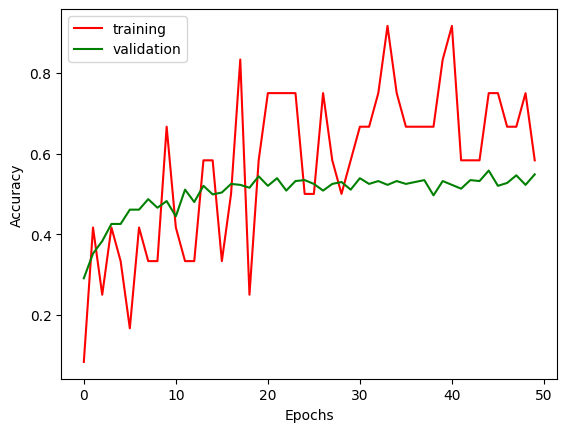

In [ ]:
make_figure(training_acc_STFT, validation_acc_STFT, name = "STFT")

In [ ]:
################################################################################
## Training and Test The CNN+SpeechFeatures ####################################
################################################################################
cnn_speech = CNN_Speech().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_speech.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_speech = {
    "x_train": x_train_Speech,
    "y_train": y_train_Speech,
    "x_valid": x_valid_Speech,
    "y_valid": y_valid_Speech
}
training_acc_Speech, validation_acc_Speech = train_model(data_speech, optimizer, criterion, cnn_speech, batch_size, num_epoch)
start_time = time.time()
test_model(cnn_speech, model_choice="Speech", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  CNN_Speech(
  (model_nn): ModuleList(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
    (5): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (8): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.6, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=350, out_features=40, bias=True)
    (12): Linear(in_features=40, out_features=10, bias=True)
    (13): Linear(in_features=10, out_features=4, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 33] loss: 1.414
[1, 66] loss: 1.400
[1, 99] loss: 1.401
[1, 132] loss: 1.399


  2%|▏         | 1/50 [00:00<00:26,  1.86it/s]

Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.26477542519569397
Epoch:  2
[2, 33] loss: 1.394
[2, 66] loss: 1.393
[2, 99] loss: 1.395
[2, 132] loss: 1.394
Check:  torch.Size([423, 22, 55, 1])


  4%|▍         | 2/50 [00:00<00:21,  2.18it/s]

Validation Accuracy: 0.2529550790786743
Epoch:  3
[3, 33] loss: 1.386
[3, 66] loss: 1.388


  6%|▌         | 3/50 [00:01<00:20,  2.31it/s]

[3, 99] loss: 1.391
[3, 132] loss: 1.391
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24822695553302765
Epoch:  4
[4, 33] loss: 1.389
[4, 66] loss: 1.390
[4, 99] loss: 1.388


  8%|▊         | 4/50 [00:01<00:19,  2.38it/s]

[4, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2600472867488861
Epoch:  5
[5, 33] loss: 1.389
[5, 66] loss: 1.385
[5, 99] loss: 1.387
[5, 132] loss: 1.391
Check:  torch.Size([423, 22, 55, 1])


 10%|█         | 5/50 [00:02<00:18,  2.41it/s]

Validation Accuracy: 0.21276596188545227
Epoch:  6
[6, 33] loss: 1.387
[6, 66] loss: 1.389


 12%|█▏        | 6/50 [00:02<00:17,  2.45it/s]

[6, 99] loss: 1.391
[6, 132] loss: 1.387
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.26241135597229004
Epoch:  7
[7, 33] loss: 1.387


 14%|█▍        | 7/50 [00:02<00:17,  2.48it/s]

[7, 66] loss: 1.385
[7, 99] loss: 1.386
[7, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.22695034742355347
Epoch:  8
[8, 33] loss: 1.386
[8, 66] loss: 1.384
[8, 99] loss: 1.385


 16%|█▌        | 8/50 [00:03<00:16,  2.50it/s]

[8, 132] loss: 1.388
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2505910098552704
Epoch:  9
[9, 33] loss: 1.384
[9, 66] loss: 1.386


 18%|█▊        | 9/50 [00:03<00:16,  2.51it/s]

[9, 99] loss: 1.384
[9, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2222222238779068
Epoch:  10
[10, 33] loss: 1.387
[10, 66] loss: 1.385
[10, 99] loss: 1.387


 20%|██        | 10/50 [00:04<00:15,  2.50it/s]

[10, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2222222238779068
Epoch:  11
[11, 33] loss: 1.384
[11, 66] loss: 1.384
[11, 99] loss: 1.386
[11, 132] loss: 1.385


 22%|██▏       | 11/50 [00:04<00:15,  2.49it/s]

Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.23404255509376526
Epoch:  12
[12, 33] loss: 1.383
[12, 66] loss: 1.384


 24%|██▍       | 12/50 [00:04<00:15,  2.50it/s]

[12, 99] loss: 1.387
[12, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2151300311088562
Epoch:  13
[13, 33] loss: 1.382
[13, 66] loss: 1.387
[13, 99] loss: 1.383


 26%|██▌       | 13/50 [00:05<00:14,  2.51it/s]

[13, 132] loss: 1.388
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.1843971610069275
Epoch:  14
[14, 33] loss: 1.383


 28%|██▊       | 14/50 [00:05<00:14,  2.51it/s]

[14, 66] loss: 1.384
[14, 99] loss: 1.383
[14, 132] loss: 1.384
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24586288630962372
Epoch:  15
[15, 33] loss: 1.383
[15, 66] loss: 1.384
[15, 99] loss: 1.381


 30%|███       | 15/50 [00:06<00:13,  2.51it/s]

[15, 132] loss: 1.383
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2600472867488861
Epoch:  16
[16, 33] loss: 1.382
[16, 66] loss: 1.385


 32%|███▏      | 16/50 [00:06<00:13,  2.52it/s]

[16, 99] loss: 1.382
[16, 132] loss: 1.382
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.23877067863941193
Epoch:  17
[17, 33] loss: 1.382
[17, 66] loss: 1.381
[17, 99] loss: 1.380


 34%|███▍      | 17/50 [00:06<00:13,  2.51it/s]

[17, 132] loss: 1.386
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.26950353384017944
Epoch:  18
[18, 33] loss: 1.385
[18, 66] loss: 1.381
[18, 99] loss: 1.379
[18, 132] loss: 1.384
Check:  torch.Size([423, 22, 55, 1])


 36%|███▌      | 18/50 [00:07<00:12,  2.51it/s]

Validation Accuracy: 0.2080378234386444
Epoch:  19
[19, 33] loss: 1.386
[19, 66] loss: 1.380
[19, 99] loss: 1.384
[19, 132] loss: 1.383
Check:  torch.Size([423, 22, 55, 1])


 38%|███▊      | 19/50 [00:07<00:12,  2.49it/s]

Validation Accuracy: 0.23404255509376526
Epoch:  20
[20, 33] loss: 1.383
[20, 66] loss: 1.381


 40%|████      | 20/50 [00:08<00:12,  2.49it/s]

[20, 99] loss: 1.382
[20, 132] loss: 1.381
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.21749408543109894
Epoch:  21
[21, 33] loss: 1.380
[21, 66] loss: 1.384
[21, 99] loss: 1.383


 42%|████▏     | 21/50 [00:08<00:11,  2.50it/s]

[21, 132] loss: 1.381
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24586288630962372
Epoch:  22
[22, 33] loss: 1.377
[22, 66] loss: 1.379
[22, 99] loss: 1.383
[22, 132] loss: 1.385


 44%|████▍     | 22/50 [00:08<00:11,  2.49it/s]

Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.19385342299938202
Epoch:  23
[23, 33] loss: 1.380
[23, 66] loss: 1.379


 46%|████▌     | 23/50 [00:09<00:10,  2.50it/s]

[23, 99] loss: 1.380
[23, 132] loss: 1.384
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.19148936867713928
Epoch:  24
[24, 33] loss: 1.377
[24, 66] loss: 1.379
[24, 99] loss: 1.382


 48%|████▊     | 24/50 [00:09<00:10,  2.50it/s]

[24, 132] loss: 1.382
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2364066243171692
Epoch:  25
[25, 33] loss: 1.380
[25, 66] loss: 1.383
[25, 99] loss: 1.378
[25, 132] loss: 1.374
Check:  torch.Size([423, 22, 55, 1])


 50%|█████     | 25/50 [00:10<00:10,  2.49it/s]

Validation Accuracy: 0.2009456306695938
Epoch:  26
[26, 33] loss: 1.382
[26, 66] loss: 1.380


 52%|█████▏    | 26/50 [00:10<00:09,  2.50it/s]

[26, 99] loss: 1.379
[26, 132] loss: 1.377
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24113474786281586
Epoch:  27
[27, 33] loss: 1.378
[27, 66] loss: 1.380


 54%|█████▍    | 27/50 [00:10<00:09,  2.48it/s]

[27, 99] loss: 1.375
[27, 132] loss: 1.374
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.23404255509376526
Epoch:  28
[28, 33] loss: 1.372
[28, 66] loss: 1.381
[28, 99] loss: 1.381


 56%|█████▌    | 28/50 [00:11<00:08,  2.49it/s]

[28, 132] loss: 1.377
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2600472867488861
Epoch:  29
[29, 33] loss: 1.376
[29, 66] loss: 1.374
[29, 99] loss: 1.379
[29, 132] loss: 1.381
Check:  torch.Size([423, 22, 55, 1])


 58%|█████▊    | 29/50 [00:11<00:08,  2.48it/s]

Validation Accuracy: 0.23167848587036133
Epoch:  30
[30, 33] loss: 1.377
[30, 66] loss: 1.373


 60%|██████    | 30/50 [00:12<00:08,  2.49it/s]

[30, 99] loss: 1.378
[30, 132] loss: 1.376
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.21749408543109894
Epoch:  31
[31, 33] loss: 1.375
[31, 66] loss: 1.374
[31, 99] loss: 1.372
[31, 132] loss: 1.376
Check:  torch.Size([423, 22, 55, 1])


 62%|██████▏   | 31/50 [00:12<00:07,  2.50it/s]

Validation Accuracy: 0.21749408543109894
Epoch:  32
[32, 33] loss: 1.375
[32, 66] loss: 1.373


 64%|██████▍   | 32/50 [00:12<00:07,  2.50it/s]

[32, 99] loss: 1.375
[32, 132] loss: 1.378
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.22458629310131073
Epoch:  33
[33, 33] loss: 1.377
[33, 66] loss: 1.371
[33, 99] loss: 1.375


 66%|██████▌   | 33/50 [00:13<00:06,  2.52it/s]

[33, 132] loss: 1.375
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.23877067863941193
Epoch:  34
[34, 33] loss: 1.374


 68%|██████▊   | 34/50 [00:13<00:06,  2.52it/s]

[34, 66] loss: 1.372
[34, 99] loss: 1.369
[34, 132] loss: 1.377
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2364066243171692
Epoch:  35
[35, 33] loss: 1.372
[35, 66] loss: 1.372
[35, 99] loss: 1.370


 70%|███████   | 35/50 [00:14<00:05,  2.51it/s]

[35, 132] loss: 1.377
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.22695034742355347
Epoch:  36
[36, 33] loss: 1.378
[36, 66] loss: 1.374


 72%|███████▏  | 36/50 [00:14<00:05,  2.52it/s]

[36, 99] loss: 1.374
[36, 132] loss: 1.369
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.21276596188545227
Epoch:  37
[37, 33] loss: 1.373
[37, 66] loss: 1.378
[37, 99] loss: 1.373


 74%|███████▍  | 37/50 [00:14<00:05,  2.52it/s]

[37, 132] loss: 1.375
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2505910098552704
Epoch:  38
[38, 33] loss: 1.369
[38, 66] loss: 1.371
[38, 99] loss: 1.370
[38, 132] loss: 1.372
Check:  torch.Size([423, 22, 55, 1])


 76%|███████▌  | 38/50 [00:15<00:04,  2.51it/s]

Validation Accuracy: 0.22458629310131073
Epoch:  39
[39, 33] loss: 1.364
[39, 66] loss: 1.374


 78%|███████▊  | 39/50 [00:15<00:04,  2.53it/s]

[39, 99] loss: 1.376
[39, 132] loss: 1.371
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2293144166469574
Epoch:  40
[40, 33] loss: 1.365


 80%|████████  | 40/50 [00:16<00:03,  2.53it/s]

[40, 66] loss: 1.364
[40, 99] loss: 1.375
[40, 132] loss: 1.364
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.23404255509376526
Epoch:  41
[41, 33] loss: 1.366
[41, 66] loss: 1.370


 82%|████████▏ | 41/50 [00:16<00:03,  2.52it/s]

[41, 99] loss: 1.366
[41, 132] loss: 1.369
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24113474786281586
Epoch:  42
[42, 33] loss: 1.374
[42, 66] loss: 1.378
[42, 99] loss: 1.366


 84%|████████▍ | 42/50 [00:16<00:03,  2.52it/s]

[42, 132] loss: 1.374
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.22458629310131073
Epoch:  43
[43, 33] loss: 1.368


 86%|████████▌ | 43/50 [00:17<00:02,  2.52it/s]

[43, 66] loss: 1.370
[43, 99] loss: 1.367
[43, 132] loss: 1.373
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2671394944190979
Epoch:  44
[44, 33] loss: 1.368
[44, 66] loss: 1.366


 88%|████████▊ | 44/50 [00:17<00:02,  2.52it/s]

[44, 99] loss: 1.366
[44, 132] loss: 1.377
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2600472867488861
Epoch:  45
[45, 33] loss: 1.363


 90%|█████████ | 45/50 [00:18<00:01,  2.52it/s]

[45, 66] loss: 1.374
[45, 99] loss: 1.364
[45, 132] loss: 1.369
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2529550790786743
Epoch:  46
[46, 33] loss: 1.371
[46, 66] loss: 1.360


 92%|█████████▏| 46/50 [00:18<00:01,  2.51it/s]

[46, 99] loss: 1.370
[46, 132] loss: 1.369
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24822695553302765
Epoch:  47
[47, 33] loss: 1.368
[47, 66] loss: 1.367
[47, 99] loss: 1.366


 94%|█████████▍| 47/50 [00:18<00:01,  2.51it/s]

[47, 132] loss: 1.374
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2293144166469574
Epoch:  48
[48, 33] loss: 1.361


 96%|█████████▌| 48/50 [00:19<00:00,  2.51it/s]

[48, 66] loss: 1.359
[48, 99] loss: 1.368
[48, 132] loss: 1.373
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.21985815465450287
Epoch:  49
[49, 33] loss: 1.364
[49, 66] loss: 1.369
[49, 99] loss: 1.375


 98%|█████████▊| 49/50 [00:19<00:00,  2.51it/s]

[49, 132] loss: 1.364
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.24586288630962372
Epoch:  50
[50, 33] loss: 1.361


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

[50, 66] loss: 1.363
[50, 99] loss: 1.368
[50, 132] loss: 1.367
Check:  torch.Size([423, 22, 55, 1])
Validation Accuracy: 0.2529550790786743


Finish Training
Test accuracy for  Speech is:  0.27313769751693
Time To Run:  1.4266505241394043 seconds


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


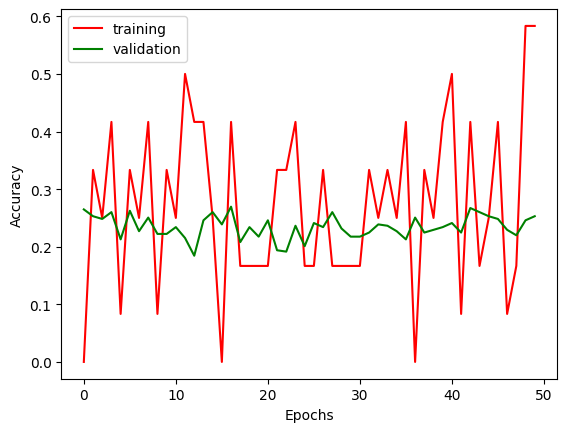

In [ ]:
make_figure(training_acc_Speech, validation_acc_Speech, name = "EEG+SpeechFeature")

In [ ]:
###################################################################################
## Training and Test The EEGNet with Annealing ####################################
###################################################################################

eeg_net = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eeg_net.parameters(), lr=1e-2, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eeg = {
    "x_train": x_train_EEG,
    "y_train": y_train_EEG,
    "x_valid": x_valid_EEG,
    "y_valid": y_valid_EEG
}
training_acc_EEG, validation_acc_EEG = train_model(data_eeg, optimizer, criterion, eeg_net, batch_size, num_epoch, anneal_=True,  T_mult=1)
start_time = time.time()
test_model(eeg_net, model_choice="EEG", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Annealing
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.336
[1, 52] loss: 1.219
[1, 78] loss: 1.223
[1, 104] loss: 1.153
Check:  torch.Size([423, 1, 22, 400])


  2%|▏         | 1/50 [00:00<00:43,  1.12it/s]

Validation Accuracy: 0.4066193997859955
Epoch:  2
[2, 26] loss: 1.112
[2, 52] loss: 1.108
[2, 78] loss: 1.064


  4%|▍         | 2/50 [00:01<00:39,  1.20it/s]

[2, 104] loss: 1.049
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5153664350509644
Epoch:  3
[3, 26] loss: 0.979
[3, 52] loss: 1.006
[3, 78] loss: 0.965
[3, 104] loss: 0.939


  6%|▌         | 3/50 [00:02<00:38,  1.23it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5721040368080139
Epoch:  4
[4, 26] loss: 0.911
[4, 52] loss: 0.884
[4, 78] loss: 0.882
[4, 104] loss: 0.812


  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5839243531227112
Epoch:  5
[5, 26] loss: 0.821
[5, 52] loss: 0.820
[5, 78] loss: 0.791
[5, 104] loss: 0.792


 10%|█         | 5/50 [00:04<00:35,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6477541327476501
Epoch:  6
[6, 26] loss: 0.764
[6, 52] loss: 0.779
[6, 78] loss: 0.762
[6, 104] loss: 0.728


 12%|█▏        | 6/50 [00:04<00:34,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  7
[7, 26] loss: 0.689
[7, 52] loss: 0.705
[7, 78] loss: 0.726
[7, 104] loss: 0.683


 14%|█▍        | 7/50 [00:05<00:34,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6643025875091553
Epoch:  8
[8, 26] loss: 0.645
[8, 52] loss: 0.680
[8, 78] loss: 0.636
[8, 104] loss: 0.660


 16%|█▌        | 8/50 [00:06<00:33,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6926714181900024
Epoch:  9
[9, 26] loss: 0.619
[9, 52] loss: 0.617
[9, 78] loss: 0.631
[9, 104] loss: 0.620


 18%|█▊        | 9/50 [00:07<00:32,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  10
[10, 26] loss: 0.625
[10, 52] loss: 0.616
[10, 78] loss: 0.600
[10, 104] loss: 0.619


 20%|██        | 10/50 [00:08<00:31,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Reset scheduler after finishing epoch:  10
Epoch:  11
[11, 26] loss: 0.771
[11, 52] loss: 0.762
[11, 78] loss: 0.787
[11, 104] loss: 0.837


 22%|██▏       | 11/50 [00:08<00:30,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6643025875091553
Epoch:  12
[12, 26] loss: 0.775
[12, 52] loss: 0.726
[12, 78] loss: 0.757
[12, 104] loss: 0.755


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6690307259559631
Epoch:  13
[13, 26] loss: 0.694
[13, 52] loss: 0.716
[13, 78] loss: 0.702
[13, 104] loss: 0.703


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6713948249816895
Epoch:  14
[14, 26] loss: 0.649
[14, 52] loss: 0.691
[14, 78] loss: 0.665
[14, 104] loss: 0.655


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6666666865348816
Epoch:  15
[15, 26] loss: 0.641
[15, 52] loss: 0.647
[15, 78] loss: 0.643
[15, 104] loss: 0.622


 30%|███       | 15/50 [00:11<00:27,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6879432797431946
Epoch:  16
[16, 26] loss: 0.588
[16, 52] loss: 0.575
[16, 78] loss: 0.606
[16, 104] loss: 0.597


 32%|███▏      | 16/50 [00:12<00:27,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6784870028495789
Epoch:  17
[17, 26] loss: 0.562
[17, 52] loss: 0.566
[17, 78] loss: 0.578
[17, 104] loss: 0.564


 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6879432797431946
Epoch:  18
[18, 26] loss: 0.548
[18, 52] loss: 0.548
[18, 78] loss: 0.546
[18, 104] loss: 0.551


 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6926714181900024
Epoch:  19
[19, 26] loss: 0.529
[19, 52] loss: 0.518
[19, 78] loss: 0.516
[19, 104] loss: 0.509


 38%|███▊      | 19/50 [00:15<00:24,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7044917345046997
Epoch:  20
[20, 26] loss: 0.497
[20, 52] loss: 0.526
[20, 78] loss: 0.502
[20, 104] loss: 0.506


 40%|████      | 20/50 [00:15<00:23,  1.26it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7021276354789734
Reset scheduler after finishing epoch:  20
Epoch:  21
[21, 26] loss: 0.636
[21, 52] loss: 0.701
[21, 78] loss: 0.692
[21, 104] loss: 0.722


 42%|████▏     | 21/50 [00:16<00:23,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6241135001182556
Epoch:  22
[22, 26] loss: 0.714
[22, 52] loss: 0.696
[22, 78] loss: 0.696
[22, 104] loss: 0.669


 44%|████▍     | 22/50 [00:17<00:22,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6903073191642761
Epoch:  23
[23, 26] loss: 0.670
[23, 52] loss: 0.666
[23, 78] loss: 0.658
[23, 104] loss: 0.611


 46%|████▌     | 23/50 [00:18<00:21,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Epoch:  24
[24, 26] loss: 0.607
[24, 52] loss: 0.635
[24, 78] loss: 0.591
[24, 104] loss: 0.625


 48%|████▊     | 24/50 [00:19<00:20,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6761229038238525
Epoch:  25
[25, 26] loss: 0.582
[25, 52] loss: 0.558
[25, 78] loss: 0.585
[25, 104] loss: 0.598


 50%|█████     | 25/50 [00:19<00:19,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6926714181900024
Epoch:  26
[26, 26] loss: 0.578
[26, 52] loss: 0.553
[26, 78] loss: 0.531
[26, 104] loss: 0.543


 52%|█████▏    | 26/50 [00:20<00:19,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  27
[27, 26] loss: 0.527
[27, 52] loss: 0.551
[27, 78] loss: 0.532
[27, 104] loss: 0.490


 54%|█████▍    | 27/50 [00:21<00:18,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7115839123725891
Epoch:  28
[28, 26] loss: 0.490
[28, 52] loss: 0.482
[28, 78] loss: 0.512
[28, 104] loss: 0.490


 56%|█████▌    | 28/50 [00:22<00:17,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7281323671340942
Epoch:  29
[29, 26] loss: 0.471
[29, 52] loss: 0.452
[29, 78] loss: 0.468
[29, 104] loss: 0.461


 58%|█████▊    | 29/50 [00:23<00:16,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7186761498451233
Epoch:  30
[30, 26] loss: 0.463
[30, 52] loss: 0.446
[30, 78] loss: 0.485
[30, 104] loss: 0.477


 60%|██████    | 30/50 [00:23<00:16,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7139480113983154
Reset scheduler after finishing epoch:  30
Epoch:  31
[31, 26] loss: 0.556
[31, 52] loss: 0.634
[31, 78] loss: 0.661
[31, 104] loss: 0.650


 62%|██████▏   | 31/50 [00:24<00:15,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6761229038238525
Epoch:  32
[32, 26] loss: 0.594
[32, 52] loss: 0.643
[32, 78] loss: 0.620
[32, 104] loss: 0.656


 64%|██████▍   | 32/50 [00:25<00:14,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6784870028495789
Epoch:  33
[33, 26] loss: 0.601
[33, 52] loss: 0.593
[33, 78] loss: 0.584
[33, 104] loss: 0.605


 66%|██████▌   | 33/50 [00:26<00:13,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  34
[34, 26] loss: 0.588
[34, 52] loss: 0.545
[34, 78] loss: 0.620
[34, 104] loss: 0.533


 68%|██████▊   | 34/50 [00:27<00:12,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6973995566368103
Epoch:  35
[35, 26] loss: 0.556
[35, 52] loss: 0.549
[35, 78] loss: 0.585
[35, 104] loss: 0.523


 70%|███████   | 35/50 [00:27<00:12,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6903073191642761
Epoch:  36
[36, 26] loss: 0.488
[36, 52] loss: 0.511
[36, 78] loss: 0.493
[36, 104] loss: 0.538


 72%|███████▏  | 36/50 [00:28<00:11,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7352246046066284
Epoch:  37
[37, 26] loss: 0.484
[37, 52] loss: 0.463
[37, 78] loss: 0.496
[37, 104] loss: 0.495


 74%|███████▍  | 37/50 [00:29<00:10,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7186761498451233
Epoch:  38
[38, 26] loss: 0.485
[38, 52] loss: 0.448
[38, 78] loss: 0.435
[38, 104] loss: 0.492


 76%|███████▌  | 38/50 [00:30<00:09,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7210401892662048
Epoch:  39
[39, 26] loss: 0.475
[39, 52] loss: 0.449
[39, 78] loss: 0.436
[39, 104] loss: 0.412


 78%|███████▊  | 39/50 [00:31<00:08,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7352246046066284
Epoch:  40
[40, 26] loss: 0.418
[40, 52] loss: 0.439
[40, 78] loss: 0.441
[40, 104] loss: 0.435


 80%|████████  | 40/50 [00:32<00:08,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7304964661598206
Reset scheduler after finishing epoch:  40
Epoch:  41
[41, 26] loss: 0.596
[41, 52] loss: 0.627
[41, 78] loss: 0.606
[41, 104] loss: 0.633


 82%|████████▏ | 41/50 [00:32<00:07,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6643025875091553
Epoch:  42
[42, 26] loss: 0.574
[42, 52] loss: 0.588
[42, 78] loss: 0.563
[42, 104] loss: 0.616


 84%|████████▍ | 42/50 [00:33<00:06,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  43
[43, 26] loss: 0.576
[43, 52] loss: 0.630
[43, 78] loss: 0.547
[43, 104] loss: 0.527


 86%|████████▌ | 43/50 [00:34<00:05,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6572104096412659
Epoch:  44
[44, 26] loss: 0.523
[44, 52] loss: 0.537
[44, 78] loss: 0.596
[44, 104] loss: 0.530


 88%|████████▊ | 44/50 [00:35<00:04,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7021276354789734
Epoch:  45
[45, 26] loss: 0.500
[45, 52] loss: 0.555
[45, 78] loss: 0.499
[45, 104] loss: 0.503


 90%|█████████ | 45/50 [00:36<00:04,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7115839123725891
Epoch:  46
[46, 26] loss: 0.491
[46, 52] loss: 0.511
[46, 78] loss: 0.489
[46, 104] loss: 0.459


 92%|█████████▏| 46/50 [00:36<00:03,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7115839123725891
Epoch:  47
[47, 26] loss: 0.495
[47, 52] loss: 0.432
[47, 78] loss: 0.450
[47, 104] loss: 0.426


 94%|█████████▍| 47/50 [00:37<00:02,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7044917345046997
Epoch:  48
[48, 26] loss: 0.458
[48, 52] loss: 0.426
[48, 78] loss: 0.419
[48, 104] loss: 0.410


 96%|█████████▌| 48/50 [00:38<00:01,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7139480113983154
Epoch:  49
[49, 26] loss: 0.395
[49, 52] loss: 0.423
[49, 78] loss: 0.413
[49, 104] loss: 0.402


 98%|█████████▊| 49/50 [00:39<00:00,  1.24it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7186761498451233
Epoch:  50
[50, 26] loss: 0.395
[50, 52] loss: 0.412
[50, 78] loss: 0.386
[50, 104] loss: 0.388


100%|██████████| 50/50 [00:40<00:00,  1.25it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7234042286872864
Reset scheduler after finishing epoch:  50
Finish Training


Test accuracy for  EEG is:  0.7494356659142212
Time To Run:  0.20669794082641602 seconds


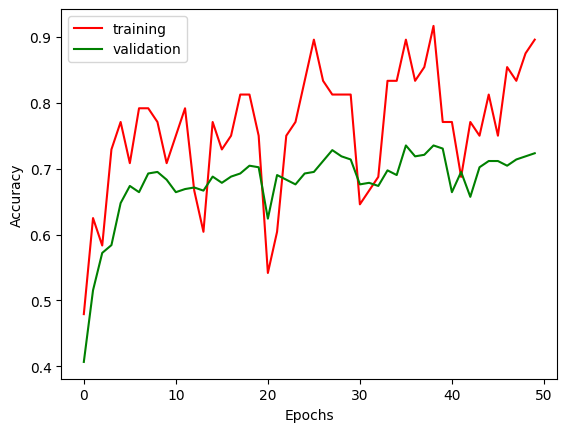

In [ ]:
make_figure(training_acc_EEG, validation_acc_EEG, name = "EEG+CosineAnnealing")

In [ ]:
###################################################################################
## Training and Test The EEGNet with label_smoothing ##############################
###################################################################################
eeg_net = EEGNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(eeg_net.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eeg = {
    "x_train": x_train_EEG,
    "y_train": y_train_EEG,
    "x_valid": x_valid_EEG,
    "y_valid": y_valid_EEG
}
training_acc_EEG_labelsm, validation_acc_EEG_labelsm = train_model(data_eeg, optimizer, criterion, eeg_net, batch_size, num_epoch, anneal_=False,  T_mult=1)
start_time = time.time()
test_model(eeg_net, model_choice="EEG", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.353
[1, 52] loss: 1.307
[1, 78] loss: 1.252
[1, 104] loss: 1.186
Check:  torch.Size([423, 1, 22, 400])


  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

Validation Accuracy: 0.49172577261924744
Epoch:  2
[2, 26] loss: 1.151
[2, 52] loss: 1.135
[2, 78] loss: 1.108


  4%|▍         | 2/50 [00:01<00:38,  1.23it/s]

[2, 104] loss: 1.099
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5579196214675903
Epoch:  3
[3, 26] loss: 1.062
[3, 52] loss: 1.048
[3, 78] loss: 1.012
[3, 104] loss: 0.996
Check:  torch.Size([423, 1, 22, 400])


  6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

Validation Accuracy: 0.5981087684631348
Epoch:  4
[4, 26] loss: 0.976
[4, 52] loss: 0.975
[4, 78] loss: 0.967


  8%|▊         | 4/50 [00:03<00:36,  1.27it/s]

[4, 104] loss: 0.968
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6075649857521057
Epoch:  5
[5, 26] loss: 0.961
[5, 52] loss: 0.961
[5, 78] loss: 0.936
[5, 104] loss: 0.935
Check:  torch.Size([423, 1, 22, 400])


 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

Validation Accuracy: 0.6241135001182556
Epoch:  6
[6, 26] loss: 0.922
[6, 52] loss: 0.946
[6, 78] loss: 0.902


 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

[6, 104] loss: 0.910
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.652482271194458
Epoch:  7
[7, 26] loss: 0.892
[7, 52] loss: 0.895
[7, 78] loss: 0.912
[7, 104] loss: 0.916
Check:  torch.Size([423, 1, 22, 400])


 14%|█▍        | 7/50 [00:05<00:33,  1.29it/s]

Validation Accuracy: 0.6619385480880737
Epoch:  8
[8, 26] loss: 0.870
[8, 52] loss: 0.886
[8, 78] loss: 0.882


 16%|█▌        | 8/50 [00:06<00:32,  1.29it/s]

[8, 104] loss: 0.900
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6595744490623474
Epoch:  9
[9, 26] loss: 0.868
[9, 52] loss: 0.859
[9, 78] loss: 0.888
[9, 104] loss: 0.869
Check:  torch.Size([423, 1, 22, 400])


 18%|█▊        | 9/50 [00:07<00:31,  1.29it/s]

Validation Accuracy: 0.652482271194458
Epoch:  10
[10, 26] loss: 0.870
[10, 52] loss: 0.861
[10, 78] loss: 0.860


 20%|██        | 10/50 [00:07<00:31,  1.29it/s]

[10, 104] loss: 0.866
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  11
[11, 26] loss: 0.838
[11, 52] loss: 0.848
[11, 78] loss: 0.841
[11, 104] loss: 0.867
Check:  torch.Size([423, 1, 22, 400])


 22%|██▏       | 11/50 [00:08<00:30,  1.29it/s]

Validation Accuracy: 0.6595744490623474
Epoch:  12
[12, 26] loss: 0.840
[12, 52] loss: 0.820
[12, 78] loss: 0.842


 24%|██▍       | 12/50 [00:09<00:29,  1.28it/s]

[12, 104] loss: 0.873
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6666666865348816
Epoch:  13
[13, 26] loss: 0.801
[13, 52] loss: 0.837
[13, 78] loss: 0.851
[13, 104] loss: 0.862
Check:  torch.Size([423, 1, 22, 400])


 26%|██▌       | 13/50 [00:10<00:28,  1.29it/s]

Validation Accuracy: 0.6713948249816895
Epoch:  14
[14, 26] loss: 0.820
[14, 52] loss: 0.842
[14, 78] loss: 0.832


 28%|██▊       | 14/50 [00:10<00:28,  1.29it/s]

[14, 104] loss: 0.833
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6903073191642761
Epoch:  15
[15, 26] loss: 0.829
[15, 52] loss: 0.829
[15, 78] loss: 0.813
[15, 104] loss: 0.818
Check:  torch.Size([423, 1, 22, 400])


 30%|███       | 15/50 [00:11<00:27,  1.29it/s]

Validation Accuracy: 0.6997635960578918
Epoch:  16
[16, 26] loss: 0.825
[16, 52] loss: 0.835
[16, 78] loss: 0.808


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

[16, 104] loss: 0.809
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Epoch:  17
[17, 26] loss: 0.805
[17, 52] loss: 0.813
[17, 78] loss: 0.805
[17, 104] loss: 0.821
Check:  torch.Size([423, 1, 22, 400])


 34%|███▍      | 17/50 [00:13<00:25,  1.29it/s]

Validation Accuracy: 0.6832151412963867
Epoch:  18
[18, 26] loss: 0.818
[18, 52] loss: 0.817
[18, 78] loss: 0.818


 36%|███▌      | 18/50 [00:14<00:24,  1.29it/s]

[18, 104] loss: 0.803
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  19
[19, 26] loss: 0.818
[19, 52] loss: 0.795
[19, 78] loss: 0.817
[19, 104] loss: 0.797
Check:  torch.Size([423, 1, 22, 400])


 38%|███▊      | 19/50 [00:14<00:24,  1.29it/s]

Validation Accuracy: 0.6926714181900024
Epoch:  20
[20, 26] loss: 0.792
[20, 52] loss: 0.802
[20, 78] loss: 0.807


 40%|████      | 20/50 [00:15<00:23,  1.28it/s]

[20, 104] loss: 0.804
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Epoch:  21
[21, 26] loss: 0.781
[21, 52] loss: 0.789
[21, 78] loss: 0.794
[21, 104] loss: 0.814


 42%|████▏     | 21/50 [00:16<00:22,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6713948249816895
Epoch:  22
[22, 26] loss: 0.814
[22, 52] loss: 0.799
[22, 78] loss: 0.802
[22, 104] loss: 0.769
Check:  torch.Size([423, 1, 22, 400])


 44%|████▍     | 22/50 [00:17<00:21,  1.28it/s]

Validation Accuracy: 0.7068557739257812
Epoch:  23
[23, 26] loss: 0.800
[23, 52] loss: 0.791
[23, 78] loss: 0.796
[23, 104] loss: 0.787


 46%|████▌     | 23/50 [00:17<00:21,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6997635960578918
Epoch:  24
[24, 26] loss: 0.798
[24, 52] loss: 0.796
[24, 78] loss: 0.778
[24, 104] loss: 0.786
Check:  torch.Size([423, 1, 22, 400])


 48%|████▊     | 24/50 [00:18<00:20,  1.28it/s]

Validation Accuracy: 0.7139480113983154
Epoch:  25
[25, 26] loss: 0.774
[25, 52] loss: 0.765
[25, 78] loss: 0.774


 50%|█████     | 25/50 [00:19<00:19,  1.28it/s]

[25, 104] loss: 0.796
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  26
[26, 26] loss: 0.797
[26, 52] loss: 0.774
[26, 78] loss: 0.769
[26, 104] loss: 0.798


 52%|█████▏    | 26/50 [00:20<00:18,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6903073191642761
Epoch:  27
[27, 26] loss: 0.779
[27, 52] loss: 0.774
[27, 78] loss: 0.777
[27, 104] loss: 0.765


 54%|█████▍    | 27/50 [00:21<00:18,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Epoch:  28
[28, 26] loss: 0.758
[28, 52] loss: 0.777
[28, 78] loss: 0.776
[28, 104] loss: 0.782
Check:  torch.Size([423, 1, 22, 400])


 56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

Validation Accuracy: 0.6973995566368103
Epoch:  29
[29, 26] loss: 0.753
[29, 52] loss: 0.766
[29, 78] loss: 0.786


 58%|█████▊    | 29/50 [00:22<00:16,  1.28it/s]

[29, 104] loss: 0.776
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.716312050819397
Epoch:  30
[30, 26] loss: 0.748
[30, 52] loss: 0.756
[30, 78] loss: 0.782
[30, 104] loss: 0.776


 60%|██████    | 30/50 [00:23<00:15,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7210401892662048
Epoch:  31
[31, 26] loss: 0.755
[31, 52] loss: 0.746
[31, 78] loss: 0.755
[31, 104] loss: 0.780


 62%|██████▏   | 31/50 [00:24<00:14,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Epoch:  32
[32, 26] loss: 0.752
[32, 52] loss: 0.766
[32, 78] loss: 0.782
[32, 104] loss: 0.766


 64%|██████▍   | 32/50 [00:25<00:14,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  33
[33, 26] loss: 0.745
[33, 52] loss: 0.770
[33, 78] loss: 0.784
[33, 104] loss: 0.760
Check:  torch.Size([423, 1, 22, 400])


 66%|██████▌   | 33/50 [00:25<00:13,  1.27it/s]

Validation Accuracy: 0.7139480113983154
Epoch:  34
[34, 26] loss: 0.759
[34, 52] loss: 0.751
[34, 78] loss: 0.773


 68%|██████▊   | 34/50 [00:26<00:12,  1.27it/s]

[34, 104] loss: 0.747
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.716312050819397
Epoch:  35
[35, 26] loss: 0.750
[35, 52] loss: 0.750
[35, 78] loss: 0.755
[35, 104] loss: 0.748


 70%|███████   | 35/50 [00:27<00:11,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6879432797431946
Epoch:  36
[36, 26] loss: 0.741
[36, 52] loss: 0.737
[36, 78] loss: 0.745
[36, 104] loss: 0.769


 72%|███████▏  | 36/50 [00:28<00:10,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Epoch:  37
[37, 26] loss: 0.763
[37, 52] loss: 0.735
[37, 78] loss: 0.769
[37, 104] loss: 0.758


 74%|███████▍  | 37/50 [00:28<00:10,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Epoch:  38
[38, 26] loss: 0.755
[38, 52] loss: 0.750
[38, 78] loss: 0.737
[38, 104] loss: 0.765


 76%|███████▌  | 38/50 [00:29<00:09,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.716312050819397
Epoch:  39
[39, 26] loss: 0.766
[39, 52] loss: 0.736
[39, 78] loss: 0.744
[39, 104] loss: 0.734


 78%|███████▊  | 39/50 [00:30<00:08,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7115839123725891
Epoch:  40
[40, 26] loss: 0.738
[40, 52] loss: 0.756
[40, 78] loss: 0.731
[40, 104] loss: 0.759


 80%|████████  | 40/50 [00:31<00:07,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7139480113983154
Epoch:  41
[41, 26] loss: 0.738
[41, 52] loss: 0.745
[41, 78] loss: 0.746
[41, 104] loss: 0.734


 82%|████████▏ | 41/50 [00:32<00:07,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7139480113983154
Epoch:  42
[42, 26] loss: 0.737
[42, 52] loss: 0.733
[42, 78] loss: 0.728
[42, 104] loss: 0.749


 84%|████████▍ | 42/50 [00:32<00:06,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6997635960578918
Epoch:  43
[43, 26] loss: 0.750
[43, 52] loss: 0.752
[43, 78] loss: 0.741
[43, 104] loss: 0.729


 86%|████████▌ | 43/50 [00:33<00:05,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6997635960578918
Epoch:  44
[44, 26] loss: 0.725
[44, 52] loss: 0.727
[44, 78] loss: 0.746
[44, 104] loss: 0.732


 88%|████████▊ | 44/50 [00:34<00:04,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7234042286872864
Epoch:  45
[45, 26] loss: 0.743
[45, 52] loss: 0.739
[45, 78] loss: 0.723
[45, 104] loss: 0.725


 90%|█████████ | 45/50 [00:35<00:03,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7068557739257812
Epoch:  46
[46, 26] loss: 0.733
[46, 52] loss: 0.730
[46, 78] loss: 0.747
[46, 104] loss: 0.715


 92%|█████████▏| 46/50 [00:36<00:03,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6973995566368103
Epoch:  47
[47, 26] loss: 0.744
[47, 52] loss: 0.717
[47, 78] loss: 0.742
[47, 104] loss: 0.724


 94%|█████████▍| 47/50 [00:36<00:02,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Epoch:  48
[48, 26] loss: 0.730
[48, 52] loss: 0.708
[48, 78] loss: 0.718
[48, 104] loss: 0.735


 96%|█████████▌| 48/50 [00:37<00:01,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7186761498451233
Epoch:  49
[49, 26] loss: 0.707
[49, 52] loss: 0.736
[49, 78] loss: 0.733
[49, 104] loss: 0.723


 98%|█████████▊| 49/50 [00:38<00:00,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  50
[50, 26] loss: 0.720
[50, 52] loss: 0.726
[50, 78] loss: 0.721
[50, 104] loss: 0.727


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.73758864402771
Finish Training


Test accuracy for  EEG is:  0.7223476297968398
Time To Run:  0.19849205017089844 seconds


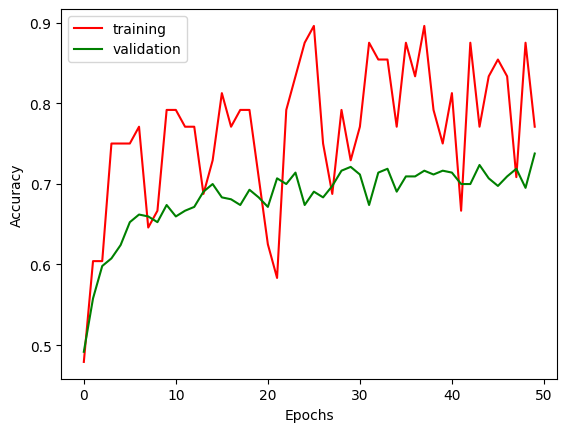

In [ ]:
make_figure(training_acc_EEG_labelsm, validation_acc_EEG_labelsm, name = "EEG+LabelSmoothing")

In [ ]:
###################################################################################
## Training and Test The EEGNet with Z-score Normalization ########################
###################################################################################

eeg_net = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eeg_net.parameters(), lr=1e-3, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eeg = {
    "x_train": x_train_EEG_z,
    "y_train": y_train_EEG_z,
    "x_valid": x_valid_EEG_z,
    "y_valid": y_valid_EEG_z
}
training_acc_EEG_z, validation_acc_EEG_z = train_model(data_eeg, optimizer, criterion, eeg_net, batch_size, num_epoch)
start_time = time.time()
test_model(eeg_net, model_choice="EEG", X_test=X_test, y_test=y_test, z_norm=True)
print("Time To Run: ", time.time() - start_time, "seconds")

Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=192, out_features=

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.351
[1, 52] loss: 1.233
[1, 78] loss: 1.150
[1, 104] loss: 1.134
Check:  torch.Size([423, 1, 22, 400])


  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

Validation Accuracy: 0.5059101581573486
Epoch:  2
[2, 26] loss: 1.076
[2, 52] loss: 1.018
[2, 78] loss: 1.020


  4%|▍         | 2/50 [00:01<00:39,  1.23it/s]

[2, 104] loss: 0.960
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5768321752548218
Epoch:  3
[3, 26] loss: 0.946
[3, 52] loss: 0.914
[3, 78] loss: 0.915
[3, 104] loss: 0.902
Check:  torch.Size([423, 1, 22, 400])


  6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

Validation Accuracy: 0.6028369069099426
Epoch:  4
[4, 26] loss: 0.873
[4, 52] loss: 0.841
[4, 78] loss: 0.854


  8%|▊         | 4/50 [00:03<00:36,  1.28it/s]

[4, 104] loss: 0.858
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.5862883925437927
Epoch:  5
[5, 26] loss: 0.806
[5, 52] loss: 0.807
[5, 78] loss: 0.862
[5, 104] loss: 0.813
Check:  torch.Size([423, 1, 22, 400])


 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

Validation Accuracy: 0.6170212626457214
Epoch:  6
[6, 26] loss: 0.796
[6, 52] loss: 0.796
[6, 78] loss: 0.812


 12%|█▏        | 6/50 [00:04<00:34,  1.29it/s]

[6, 104] loss: 0.798
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6028369069099426
Epoch:  7
[7, 26] loss: 0.759
[7, 52] loss: 0.781
[7, 78] loss: 0.820
[7, 104] loss: 0.788
Check:  torch.Size([423, 1, 22, 400])


 14%|█▍        | 7/50 [00:05<00:33,  1.29it/s]

Validation Accuracy: 0.6146572232246399
Epoch:  8
[8, 26] loss: 0.767
[8, 52] loss: 0.755
[8, 78] loss: 0.742


 16%|█▌        | 8/50 [00:06<00:32,  1.29it/s]

[8, 104] loss: 0.774
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6170212626457214
Epoch:  9
[9, 26] loss: 0.698
[9, 52] loss: 0.759
[9, 78] loss: 0.737
[9, 104] loss: 0.755
Check:  torch.Size([423, 1, 22, 400])


 18%|█▊        | 9/50 [00:07<00:31,  1.29it/s]

Validation Accuracy: 0.609929084777832
Epoch:  10
[10, 26] loss: 0.736
[10, 52] loss: 0.714
[10, 78] loss: 0.693


 20%|██        | 10/50 [00:07<00:30,  1.29it/s]

[10, 104] loss: 0.694
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6264775395393372
Epoch:  11
[11, 26] loss: 0.699
[11, 52] loss: 0.648
[11, 78] loss: 0.687
[11, 104] loss: 0.704
Check:  torch.Size([423, 1, 22, 400])


 22%|██▏       | 11/50 [00:08<00:30,  1.29it/s]

Validation Accuracy: 0.631205677986145
Epoch:  12
[12, 26] loss: 0.683
[12, 52] loss: 0.698
[12, 78] loss: 0.650


 24%|██▍       | 12/50 [00:09<00:29,  1.29it/s]

[12, 104] loss: 0.671
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6335697174072266
Epoch:  13
[13, 26] loss: 0.660
[13, 52] loss: 0.664
[13, 78] loss: 0.663
[13, 104] loss: 0.685
Check:  torch.Size([423, 1, 22, 400])


 26%|██▌       | 13/50 [00:10<00:28,  1.29it/s]

Validation Accuracy: 0.6382978558540344
Epoch:  14
[14, 26] loss: 0.618
[14, 52] loss: 0.638
[14, 78] loss: 0.693


 28%|██▊       | 14/50 [00:10<00:27,  1.29it/s]

[14, 104] loss: 0.661
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6359338164329529
Epoch:  15
[15, 26] loss: 0.627
[15, 52] loss: 0.633
[15, 78] loss: 0.657
[15, 104] loss: 0.690


 30%|███       | 15/50 [00:11<00:27,  1.29it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.673758864402771
Epoch:  16
[16, 26] loss: 0.604
[16, 52] loss: 0.648
[16, 78] loss: 0.629
[16, 104] loss: 0.616
Check:  torch.Size([423, 1, 22, 400])


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

Validation Accuracy: 0.6808510422706604
Epoch:  17
[17, 26] loss: 0.615
[17, 52] loss: 0.630
[17, 78] loss: 0.600


 34%|███▍      | 17/50 [00:13<00:25,  1.29it/s]

[17, 104] loss: 0.601
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6784870028495789
Epoch:  18
[18, 26] loss: 0.585
[18, 52] loss: 0.599
[18, 78] loss: 0.616
[18, 104] loss: 0.594


 36%|███▌      | 18/50 [00:14<00:24,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6903073191642761
Epoch:  19
[19, 26] loss: 0.598
[19, 52] loss: 0.622
[19, 78] loss: 0.579
[19, 104] loss: 0.597
Check:  torch.Size([423, 1, 22, 400])


 38%|███▊      | 19/50 [00:14<00:24,  1.28it/s]

Validation Accuracy: 0.6926714181900024
Epoch:  20
[20, 26] loss: 0.578
[20, 52] loss: 0.572
[20, 78] loss: 0.604


 40%|████      | 20/50 [00:15<00:23,  1.29it/s]

[20, 104] loss: 0.599
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  21
[21, 26] loss: 0.560
[21, 52] loss: 0.614
[21, 78] loss: 0.552
[21, 104] loss: 0.581
Check:  torch.Size([423, 1, 22, 400])


 42%|████▏     | 21/50 [00:16<00:22,  1.28it/s]

Validation Accuracy: 0.6855791807174683
Epoch:  22
[22, 26] loss: 0.563
[22, 52] loss: 0.614
[22, 78] loss: 0.551


 44%|████▍     | 22/50 [00:17<00:21,  1.28it/s]

[22, 104] loss: 0.583
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6832151412963867
Epoch:  23
[23, 26] loss: 0.547
[23, 52] loss: 0.578
[23, 78] loss: 0.574
[23, 104] loss: 0.545
Check:  torch.Size([423, 1, 22, 400])


 46%|████▌     | 23/50 [00:17<00:21,  1.29it/s]

Validation Accuracy: 0.6832151412963867
Epoch:  24
[24, 26] loss: 0.529
[24, 52] loss: 0.594
[24, 78] loss: 0.552


 48%|████▊     | 24/50 [00:18<00:20,  1.28it/s]

[24, 104] loss: 0.574
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6784870028495789
Epoch:  25
[25, 26] loss: 0.536
[25, 52] loss: 0.562
[25, 78] loss: 0.547
[25, 104] loss: 0.552


 50%|█████     | 25/50 [00:19<00:19,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  26
[26, 26] loss: 0.567
[26, 52] loss: 0.589
[26, 78] loss: 0.528
[26, 104] loss: 0.536
Check:  torch.Size([423, 1, 22, 400])


 52%|█████▏    | 26/50 [00:20<00:18,  1.28it/s]

Validation Accuracy: 0.7186761498451233
Epoch:  27
[27, 26] loss: 0.520
[27, 52] loss: 0.515
[27, 78] loss: 0.549


 54%|█████▍    | 27/50 [00:21<00:17,  1.28it/s]

[27, 104] loss: 0.572
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6973995566368103
Epoch:  28
[28, 26] loss: 0.550
[28, 52] loss: 0.538
[28, 78] loss: 0.509
[28, 104] loss: 0.491
Check:  torch.Size([423, 1, 22, 400])


 56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

Validation Accuracy: 0.6903073191642761
Epoch:  29
[29, 26] loss: 0.515
[29, 52] loss: 0.530
[29, 78] loss: 0.502


 58%|█████▊    | 29/50 [00:22<00:16,  1.28it/s]

[29, 104] loss: 0.557
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6879432797431946
Epoch:  30
[30, 26] loss: 0.514
[30, 52] loss: 0.494
[30, 78] loss: 0.511
[30, 104] loss: 0.529
Check:  torch.Size([423, 1, 22, 400])


 60%|██████    | 30/50 [00:23<00:15,  1.28it/s]

Validation Accuracy: 0.6808510422706604
Epoch:  31
[31, 26] loss: 0.492
[31, 52] loss: 0.506
[31, 78] loss: 0.532


 62%|██████▏   | 31/50 [00:24<00:14,  1.28it/s]

[31, 104] loss: 0.527
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6879432797431946
Epoch:  32
[32, 26] loss: 0.506
[32, 52] loss: 0.485
[32, 78] loss: 0.535
[32, 104] loss: 0.516


 64%|██████▍   | 32/50 [00:24<00:14,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7044917345046997
Epoch:  33
[33, 26] loss: 0.518
[33, 52] loss: 0.534
[33, 78] loss: 0.503
[33, 104] loss: 0.462


 66%|██████▌   | 33/50 [00:25<00:13,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6973995566368103
Epoch:  34
[34, 26] loss: 0.480
[34, 52] loss: 0.510
[34, 78] loss: 0.487
[34, 104] loss: 0.525
Check:  torch.Size([423, 1, 22, 400])


 68%|██████▊   | 34/50 [00:26<00:12,  1.28it/s]

Validation Accuracy: 0.7092198729515076
Epoch:  35
[35, 26] loss: 0.498
[35, 52] loss: 0.512
[35, 78] loss: 0.472


 70%|███████   | 35/50 [00:27<00:11,  1.28it/s]

[35, 104] loss: 0.502
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7021276354789734
Epoch:  36
[36, 26] loss: 0.494
[36, 52] loss: 0.488
[36, 78] loss: 0.488
[36, 104] loss: 0.480


 72%|███████▏  | 36/50 [00:28<00:10,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6926714181900024
Epoch:  37
[37, 26] loss: 0.464
[37, 52] loss: 0.484
[37, 78] loss: 0.511
[37, 104] loss: 0.499


 74%|███████▍  | 37/50 [00:28<00:10,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6926714181900024
Epoch:  38
[38, 26] loss: 0.478
[38, 52] loss: 0.473
[38, 78] loss: 0.534
[38, 104] loss: 0.527


 76%|███████▌  | 38/50 [00:29<00:09,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6973995566368103
Epoch:  39
[39, 26] loss: 0.457
[39, 52] loss: 0.508
[39, 78] loss: 0.504
[39, 104] loss: 0.492


 78%|███████▊  | 39/50 [00:30<00:08,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7115839123725891
Epoch:  40
[40, 26] loss: 0.475
[40, 52] loss: 0.481
[40, 78] loss: 0.469
[40, 104] loss: 0.510


 80%|████████  | 40/50 [00:31<00:07,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7021276354789734
Epoch:  41
[41, 26] loss: 0.463
[41, 52] loss: 0.486
[41, 78] loss: 0.490
[41, 104] loss: 0.484


 82%|████████▏ | 41/50 [00:31<00:07,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Epoch:  42
[42, 26] loss: 0.468
[42, 52] loss: 0.485
[42, 78] loss: 0.479
[42, 104] loss: 0.478


 84%|████████▍ | 42/50 [00:32<00:06,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.6808510422706604
Epoch:  43
[43, 26] loss: 0.480
[43, 52] loss: 0.441
[43, 78] loss: 0.485
[43, 104] loss: 0.420


 86%|████████▌ | 43/50 [00:33<00:05,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7210401892662048
Epoch:  44
[44, 26] loss: 0.446
[44, 52] loss: 0.464
[44, 78] loss: 0.450
[44, 104] loss: 0.529
Check:  torch.Size([423, 1, 22, 400])


 88%|████████▊ | 44/50 [00:34<00:04,  1.27it/s]

Validation Accuracy: 0.7234042286872864
Epoch:  45
[45, 26] loss: 0.449
[45, 52] loss: 0.485
[45, 78] loss: 0.474


 90%|█████████ | 45/50 [00:35<00:03,  1.27it/s]

[45, 104] loss: 0.448
Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.695035457611084
Epoch:  46
[46, 26] loss: 0.419
[46, 52] loss: 0.499
[46, 78] loss: 0.487
[46, 104] loss: 0.468


 92%|█████████▏| 46/50 [00:35<00:03,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7139480113983154
Epoch:  47
[47, 26] loss: 0.455
[47, 52] loss: 0.430
[47, 78] loss: 0.491
[47, 104] loss: 0.453


 94%|█████████▍| 47/50 [00:36<00:02,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.716312050819397
Epoch:  48
[48, 26] loss: 0.460
[48, 52] loss: 0.472
[48, 78] loss: 0.429
[48, 104] loss: 0.481


 96%|█████████▌| 48/50 [00:37<00:01,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7281323671340942
Epoch:  49
[49, 26] loss: 0.436
[49, 52] loss: 0.433
[49, 78] loss: 0.475
[49, 104] loss: 0.460


 98%|█████████▊| 49/50 [00:38<00:00,  1.27it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7257683277130127
Epoch:  50
[50, 26] loss: 0.442
[50, 52] loss: 0.464
[50, 78] loss: 0.433
[50, 104] loss: 0.476


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]

Check:  torch.Size([423, 1, 22, 400])
Validation Accuracy: 0.7092198729515076
Finish Training


Test accuracy for  EEG is:  0.6817155756207675
Time To Run:  0.24237918853759766 seconds


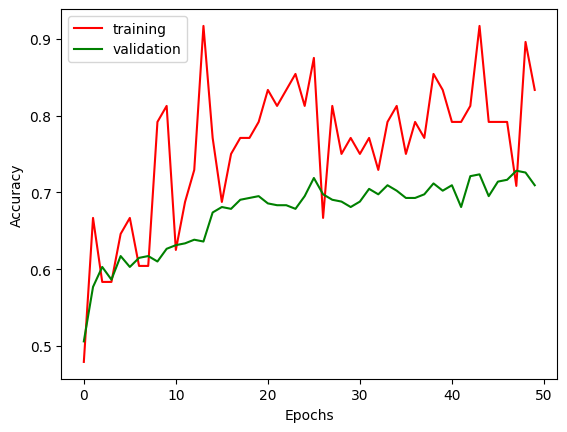

In [ ]:
make_figure(training_acc_EEG_z, validation_acc_EEG_z, name = "EEG+Z-score")